# DS 4002 Project 3
This project aims to develop a machine learning model that can automatically classify chest X-ray images as either normal or showing signs of pneumonia. By applying transfer learning with a pre-trained deep learning model, we aim to support early and accurate detection of pneumonia, contributing to more efficient medical diagnostics.

## MI2 - Exploratory Data Analysis


### 1.0 Loading Data

In [6]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/chest_xray'

Mounted at /content/drive


In [7]:
# Count images in each class
import os
import pandas as pd

counts = {'Set': [], 'Class': [], 'Image Count': []}

for split in ['train', 'test']:
    for label in ['NORMAL', 'PNEUMONIA']:
        folder = os.path.join(data_dir, split, label)
        image_count = len(os.listdir(folder))
        counts['Set'].append(split.capitalize())
        counts['Class'].append(label.capitalize())
        counts['Image Count'].append(image_count)

df = pd.DataFrame(counts)
print(df)


     Set      Class  Image Count
0  Train     Normal         1363
1  Train  Pneumonia         3910
2   Test     Normal          234
3   Test  Pneumonia          390


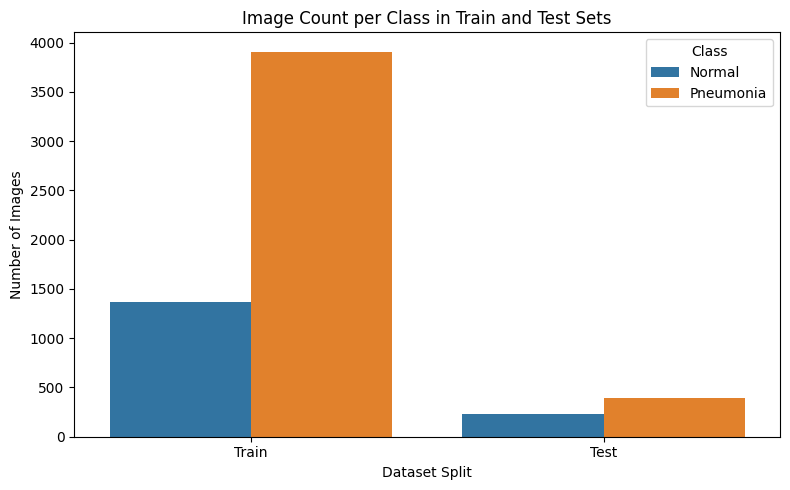

In [8]:
# Plot class distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(x='Set', y='Image Count', hue='Class', data=df)
plt.title('Image Count per Class in Train and Test Sets')
plt.ylabel('Number of Images')
plt.xlabel('Dataset Split')
plt.tight_layout()
plt.show()


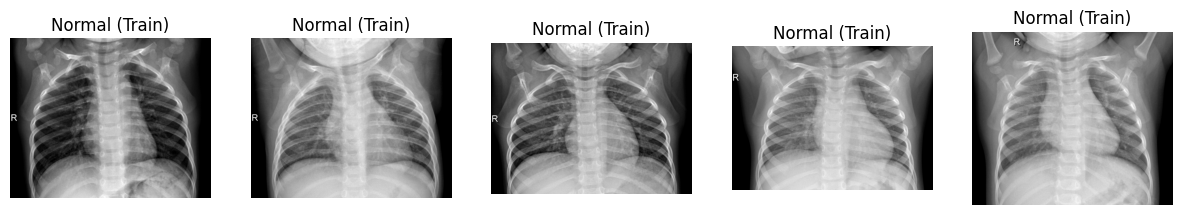

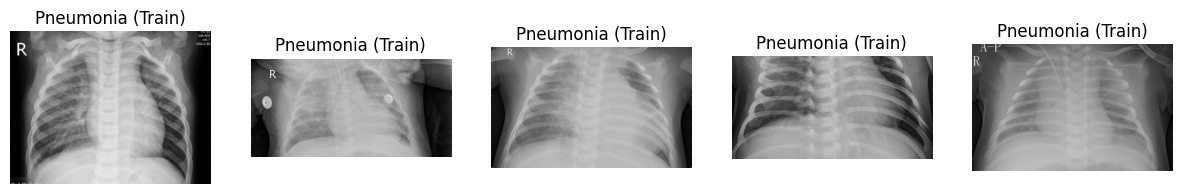

In [9]:
# Show sample images
import matplotlib.image as mpimg
import random

def show_sample_images(folder, title, n=5):
    images = os.listdir(folder)
    selected = random.sample(images, n)

    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(selected):
        img_path = os.path.join(folder, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{title}")
        plt.axis('off')
    plt.show()

# Images from each class
show_sample_images(os.path.join(data_dir, 'train/NORMAL'), "Normal (Train)")
show_sample_images(os.path.join(data_dir, 'train/PNEUMONIA'), "Pneumonia (Train)")


### 2.0 EDA for Distribution of Aspect Ratio

[PNEUMONIA] Error processing .DS_Store: cannot identify image file '/content/drive/MyDrive/chest_xray/train/PNEUMONIA/.DS_Store'


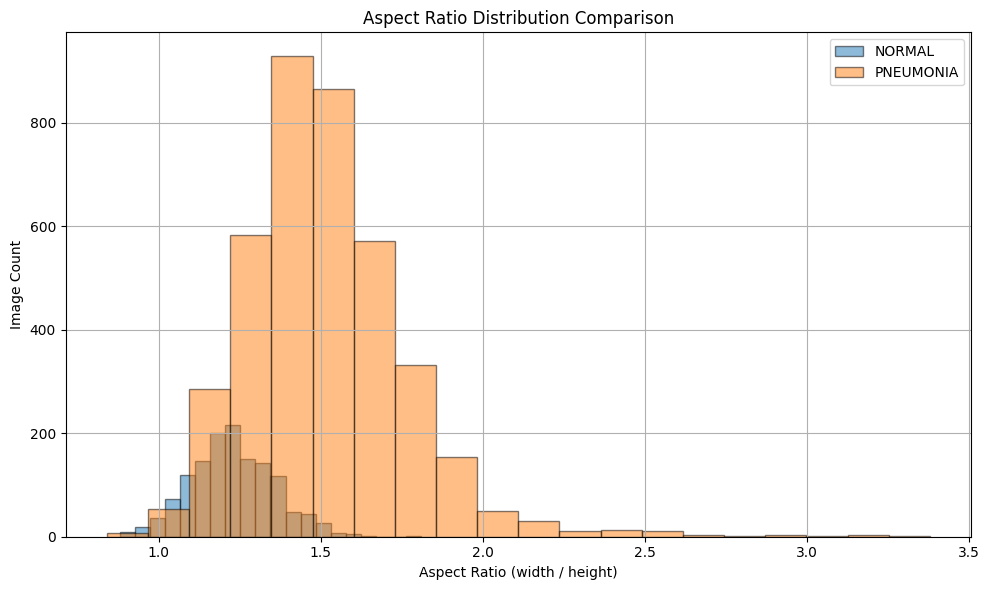

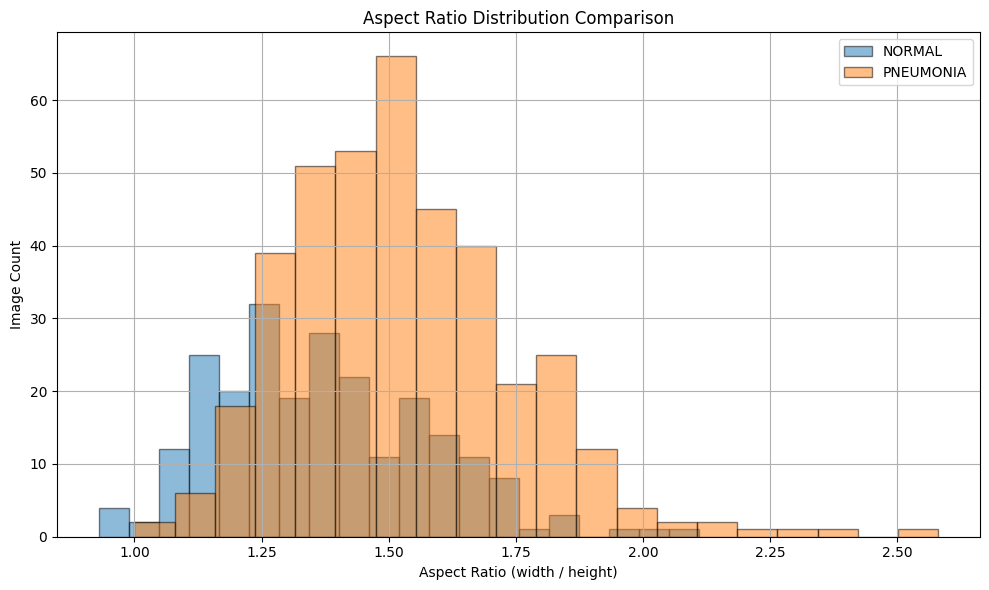

In [10]:
## EDA for Distribution of Aspect Ratio
from PIL import Image
from collections import Counter
import os
import matplotlib.pyplot as plt

def compare_aspect_ratios(folder_dict):
    """
    Analyzes and compares aspect ratio distributions across multiple folders.

    Parameters:
    - folder_dict (dict): Keys are labels (e.g., "NORMAL", "PNEUMONIA"),
                          values are folder paths.

    Outputs:
    - A combined histogram comparing aspect ratio distributions.
    """
    plt.figure(figsize=(10, 6))

    for label, folder_path in folder_dict.items():
        aspect_ratios = []

        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                with Image.open(file_path) as img:
                    width, height = img.size
                    aspect_ratio = round(width / height, 2) if height != 0 else 0
                    aspect_ratios.append(aspect_ratio)
            except Exception as e:
                print(f"[{label}] Error processing {filename}: {e}")

        # Plot histogram for this folder
        plt.hist(
            aspect_ratios, bins=20, alpha=0.5, label=label, edgecolor='black'
        )

    plt.title('Aspect Ratio Distribution Comparison')
    plt.xlabel('Aspect Ratio (width / height)')
    plt.ylabel('Image Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run aspect ratio distribution code on training set
compare_aspect_ratios({
    "NORMAL": os.path.join(data_dir, 'train/NORMAL'),
    "PNEUMONIA": os.path.join(data_dir, 'train/PNEUMONIA')
})

# Run aspect ratio distribution code on test set
compare_aspect_ratios({
    "NORMAL": os.path.join(data_dir, 'test/NORMAL'),
    "PNEUMONIA": os.path.join(data_dir, 'test/PNEUMONIA')
})

## MI3 - Analysis


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

In [12]:
import tensorflow as tf
import numpy as np
import random

# Set random seed for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [13]:
IMG_SIZE = 384
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)


Found 4219 images belonging to 2 classes.
Found 1053 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [14]:
base_model = EfficientNetV2S(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)

base_model.trainable = True  # Unfreeze all layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # smaller learning rate!
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-s (Functional)   │ (None, 12, 12, 1280)   │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,495,457 (78.18 MB)

 Trainable params: 20,341,585 (77.60 MB)

 Non-trainable params: 153,872 (601.06 KB)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=30,  # more training!
    validation_data=val_generator,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 560s 3s/step - accuracy: 0.7671 - loss: 0.5777 - val_accuracy: 0.8718 - val_loss: 0.3333
Epoch 2/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.8952 - loss: 0.3111 - val_accuracy: 0.9354 - val_loss: 0.2076
Epoch 3/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.9360 - loss: 0.2000 - val_accuracy: 0.9573 - val_loss: 0.1359
Epoch 4/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.9467 - loss: 0.1502 - val_accuracy: 0.9639 - val_loss: 0.1109
Epoch 5/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.9570 - loss: 0.1219 - val_accuracy: 0.9706 - val_loss: 0.0810
Epoch 6/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.9699 - loss: 0.0891 - val_accuracy: 0.9772 - val_loss: 0.0725
Epoch 7/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.9728 - loss: 0.0850 - val_accuracy: 0.9725 - val_loss: 0.0769
Epoch 8/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.9726 - loss: 0.0817 - val_accu

In [16]:
# Make predictions on test data
y_pred_probs = model.predict(test_generator, verbose=1)
y_preds = (y_pred_probs > 0.5).astype(int).flatten()

# Get true labels from test set
y_true = test_generator.classes


624/624 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Classification report
report = classification_report(y_true, y_preds, target_names=['Normal', 'Pneumonia'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv("classification_report.csv")
print(report_df)

# Confusion matrix
cm = confusion_matrix(y_true, y_preds)
cm_df = pd.DataFrame(cm, index=['Actual Normal', 'Actual Pneumonia'], columns=['Predicted Normal', 'Predicted Pneumonia'])
cm_df.to_csv("confusion_matrix.csv")
print(cm_df)

              precision    recall  f1-score     support
Normal         0.922414  0.914530  0.918455  234.000000
Pneumonia      0.948980  0.953846  0.951407  390.000000
accuracy       0.939103  0.939103  0.939103    0.939103
macro avg      0.935697  0.934188  0.934931  624.000000
weighted avg   0.939017  0.939103  0.939050  624.000000
                  Predicted Normal  Predicted Pneumonia
Actual Normal                  214                   20
Actual Pneumonia                18                  372


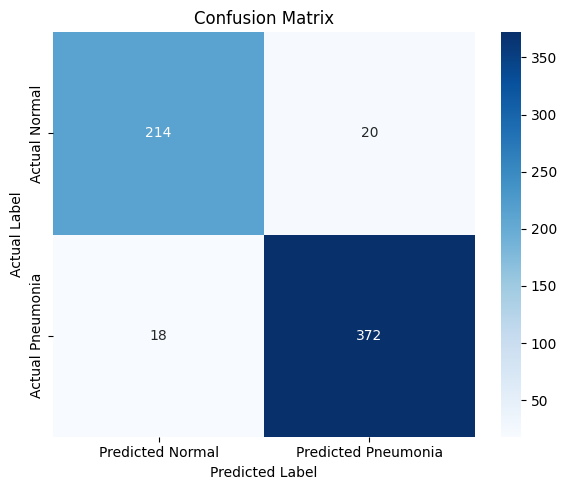

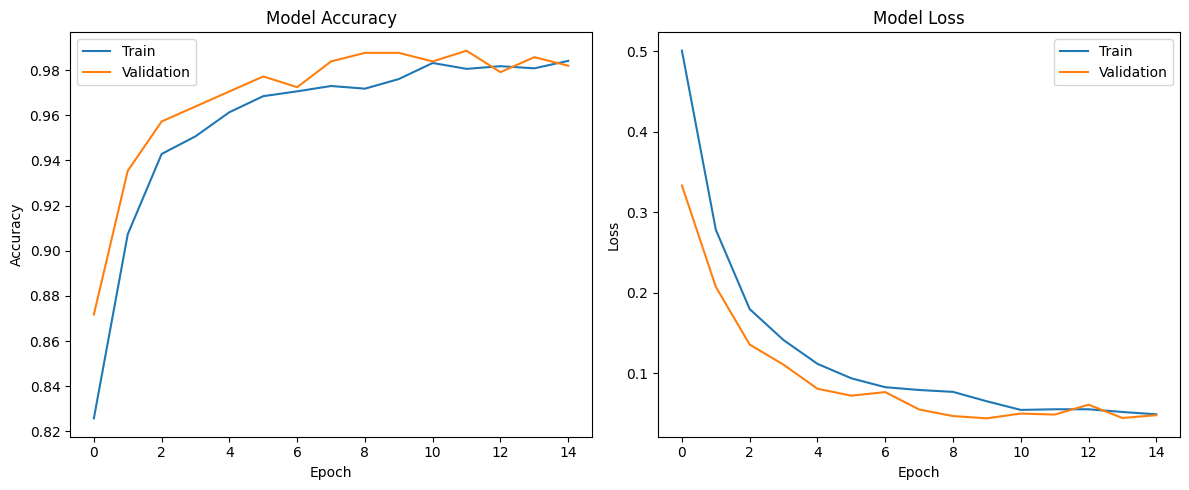

In [18]:
# Save classification report
report_df.to_csv("classification_report.csv")

# Save confusion matrix image
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

# Save training plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig("training_history_plot.png")
plt.show()


In [19]:
model.save('/content/drive/MyDrive/efficientnetv2s_chest_xray.keras')